<a href="https://colab.research.google.com/github/sidhu2690/TEST-REPO/blob/main/Specific_H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__.split('+')[0])").html

Looking in links: https://data.pyg.org/whl/torch-2.5.1.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3662080 sha256=1c2e84f5afbf98227f48a016559cf8e0f5c1bbeefcd196d77d84f58bb92f230f
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter


In [ ]:
!wget https://cernbox.cern.ch/remote.php/dav/public-files/oolDBdQegsITFcv/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet

--2025-04-02 17:02:02--  https://cernbox.cern.ch/remote.php/dav/public-files/oolDBdQegsITFcv/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184115523 (176M) [application/octet-stream]
Saving to: ‘QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet’

QCDToGGQQ_IMGjet_RH 100%[===================>] 175.59M  5.38MB/s    in 20s     

2025-04-02 17:02:23 (8.78 MB/s) - ‘QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet’ saved [184115523/184115523]



In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader as GeoDataLoader
from torch.utils.data import IterableDataset, DataLoader
from torch_geometric.nn import EdgeConv, global_mean_pool, global_max_pool
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import plotly.graph_objects as go
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neighbors import NearestNeighbors

In [ ]:
def safe_convert(x):
    if isinstance(x, (list, tuple)):
        try:
            return np.array(x, dtype=np.float32)
        except Exception:
            return np.stack([safe_convert(item) for item in x])
    elif isinstance(x, np.ndarray):
        if x.dtype == np.object_:
            return safe_convert(x.tolist())
        return x.astype(np.float32)
    else:
        return np.array(x, dtype=np.float32)

In [ ]:
class SimpleParquetDataset(IterableDataset):
    def __init__(self, file_path, batch_size=32):
        self.file_path = file_path
        self.batch_size = batch_size

    def __iter__(self):
        pf = pq.ParquetFile(self.file_path)
        for batch in pf.iter_batches(batch_size=self.batch_size, columns=['X_jets', 'y']):
            df = batch.to_pandas()
            X_batch = torch.stack([torch.tensor(safe_convert(x), dtype=torch.float32) for x in df['X_jets']])
            y_batch = torch.tensor(df['y'].values, dtype=torch.long)
            yield X_batch, y_batch

In [ ]:
def get_dataloader(file_path, batch_size=32, num_workers=0):
    dataset = SimpleParquetDataset(file_path, batch_size)
    return DataLoader(dataset, batch_size=None, num_workers=num_workers)

In [ ]:
def image_to_pc(img):
    nz_mask = np.any(img != 0, axis=-1)
    points = np.column_stack(np.where(nz_mask))
    feats = img[nz_mask]
    return points, feats

In [ ]:
def build_knn_adjacency(points, k=4, sigma=1.0):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors(points)
    distances, indices = distances[:, 1:], indices[:, 1:]
    weights = np.exp(-distances**2 / (2 * sigma**2))
    row_indices = np.repeat(np.arange(len(points)), k)
    col_indices = indices.flatten()
    A = coo_matrix((weights.flatten(), (row_indices, col_indices)), shape=(len(points), len(points)))
    return A

In [ ]:
def point_cloud_to_graph(points, features, label, image_shape=(125, 125), neighbors=4):
    adjacency = build_knn_adjacency(points, k=neighbors)
    edge_idx = torch.from_numpy(np.vstack((adjacency.row, adjacency.col))).long()
    edge_weights = torch.from_numpy(adjacency.data).float().view(-1, 1)

    feat_min = np.min(features, axis=0)
    feat_max = np.max(features, axis=0)
    feat_range = feat_max - feat_min
    feat_range[feat_range == 0] = 1
    features = (features - feat_min) / feat_range

    pos_min = np.min(points, axis=0)
    pos_max = np.max(points, axis=0)
    pos_range = pos_max - pos_min
    pos_range[pos_range == 0] = 1
    pos_features = (points - pos_min) / pos_range

    node_features = np.hstack((features, pos_features))
    data = Data(x=torch.from_numpy(node_features).float(),
                edge_index=edge_idx,
                edge_attr=edge_weights,
                y=label,
                pos=torch.tensor(points, dtype=torch.float))
    return data

In [ ]:
file_path = '/kaggle/working/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet'
dataloader = get_dataloader(file_path, batch_size=128, num_workers=0)

In [ ]:
graph_dataset = []

for X_batch, y_batch in dataloader:
    for idx, image_tensor in enumerate(X_batch):
        image_np = image_tensor.cpu().numpy().transpose(1, 2, 0)
        points, features = image_to_pc(image_np)
        graph_data = point_cloud_to_graph(points, features, y_batch[idx])
        graph_dataset.append(graph_data)

print(f'Number of graphs: {len(graph_dataset)}')

Number of graphs: 36272


In [ ]:
train_graphs, test_graphs = train_test_split(graph_dataset, test_size=0.2)
train_loader = GeoDataLoader(train_graphs, batch_size=128, shuffle=True)
test_loader = GeoDataLoader(test_graphs, batch_size=128, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
class Graph_Edge_Model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, k=4):
        super(Graph_Edge_Model, self).__init__()
        self.conv1 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        ))
        self.conv2 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Linear(hidden_channels * 2, hidden_channels * 2)
        ))
        self.conv3 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        ))
        self.fc1 = nn.Linear(hidden_channels * 2, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Graph_Edge_Model(in_channels=5, hidden_channels=128, num_classes=1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()
print(model)

Graph_Edge_Model(
  (conv1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  ))
  (conv2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  ))
  (conv3): EdgeConv(nn=Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  ))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
train_losses = []
train_accs = []
train_aucs = []

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        target = data.y.float().unsqueeze(1)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    correct = 0
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            target = data.y.float().unsqueeze(1)
            loss = criterion(out, target)
            total_loss += loss.item() * data.num_graphs

            probs = torch.sigmoid(out)
            all_probs.append(probs.cpu().numpy())
            all_targets.append(target.cpu().numpy())

            pred = (probs > 0.5).float()
            correct += int((pred == target).sum())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)

    all_probs = np.concatenate(all_probs).ravel()
    all_targets = np.concatenate(all_targets).ravel()
    auc_score = roc_auc_score(all_targets, all_probs)

    return avg_loss, accuracy, auc_score

In [ ]:
epochs = 30
for epoch in range(1, epochs+1):
    train_loss = train()
    train_loss, train_acc, train_auc = evaluate(train_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_aucs.append(train_auc)

    print(f"Epoch {epoch:03d}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}")

Epoch 001: Train Loss: 0.6633, Train Acc: 0.6019, Train AUC: 0.6485
Epoch 002: Train Loss: 0.6291, Train Acc: 0.6496, Train AUC: 0.7052
Epoch 003: Train Loss: 0.6104, Train Acc: 0.6750, Train AUC: 0.7315
Epoch 004: Train Loss: 0.6055, Train Acc: 0.6792, Train AUC: 0.7393
Epoch 005: Train Loss: 0.6026, Train Acc: 0.6835, Train AUC: 0.7441
Epoch 006: Train Loss: 0.5953, Train Acc: 0.6894, Train AUC: 0.7494
Epoch 007: Train Loss: 0.5911, Train Acc: 0.6937, Train AUC: 0.7533
Epoch 008: Train Loss: 0.5912, Train Acc: 0.6904, Train AUC: 0.7559
Epoch 009: Train Loss: 0.5880, Train Acc: 0.6927, Train AUC: 0.7577
Epoch 010: Train Loss: 0.5849, Train Acc: 0.6977, Train AUC: 0.7603
Epoch 011: Train Loss: 0.5948, Train Acc: 0.6911, Train AUC: 0.7617
Epoch 012: Train Loss: 0.5968, Train Acc: 0.6880, Train AUC: 0.7637
Epoch 013: Train Loss: 0.5945, Train Acc: 0.6852, Train AUC: 0.7651
Epoch 014: Train Loss: 0.5800, Train Acc: 0.7013, Train AUC: 0.7661
Epoch 015: Train Loss: 0.5796, Train Acc: 0.7020

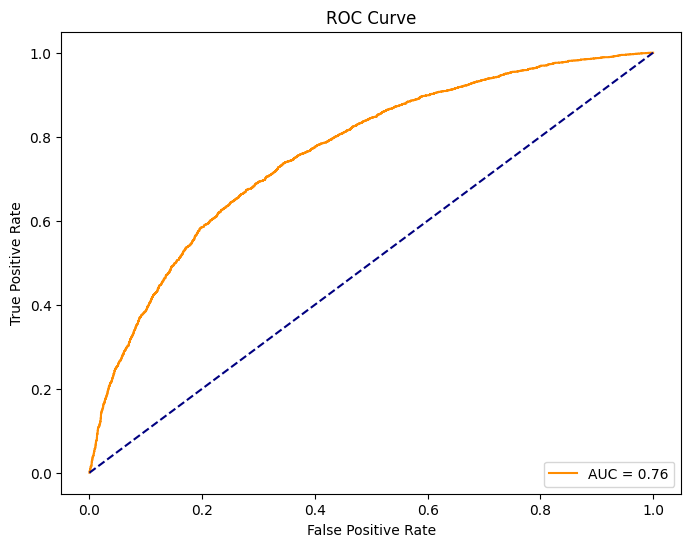

In [ ]:
def plot_roc(model, loader, device):
    model.eval()
    probs_list, targets_list = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            probs_list.append(torch.sigmoid(out).cpu().numpy())
            targets_list.append(data.y.cpu().numpy())

    probs = np.concatenate(probs_list).ravel()
    targets = np.concatenate(targets_list).ravel()

    fpr, tpr, _ = roc_curve(targets, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
    plt.plot([0, 1], [0, 1], '--', color='navy')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc(model, test_loader, device)